<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/Google_Earth_Engine%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%B0%EB%A6%BC_%EB%B3%80%ED%99%94_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine을 활용한 산림 변화 데이터 분석

안녕하세요? 이번 코드 실습은 Google Earth Engine을 활용한 산림 변화 데이터 분석을 진행해 보겠습니다. 실습 내용은 다음과 같습니다:
1. GEE를 사용하여 설악산 생물권보전지역의 경계를 추출합니다.
2. Global Forest Change 데이터셋에 관해 학습해 봅니다.
3. 2001년부터 2022년까지의 기간 동안 산림손실 면적을 계산하고, 그 결과를 그래프로 시각화해봅니다.

먼저 GEE Python API를 설치하고 인증해야 합니다.

In [ ]:
import ee
import geemap
from ipyleaflet import TileLayer
import pandas as pd
import matplotlib.pyplot as plt

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='my-project')

## 설악산 생물권보전지역 경계 추출하기

세계 보호지역 데이터베이스(WDPA: World Database on Protected Areas)는 매월 업데이트되는 보호지역에 대한 가장 최신이며 완전한 정보의 원천입니다. 이는 유엔 환경 프로그램의 세계 보전 모니터링 센터(UNEP-WCMC: United Nations Environment Programme's World Conservation Monitoring Centre)가 IUCN 및 세계보호지역위원회(WCPA: World Commission on Protected Areas)의 지원을 받아 관리하고 있습니다.

GEE에서 WDPA 폴리곤은 [FeatureCollection](https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons) 데이터 구조로 접근 가능하며, 설악산 생물권보전지역의 WDPA ID는 [5085](https://www.protectedplanet.net/5085)입니다.

In [ ]:
# 설악산 생물권보전지역 경계 추출
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
seorak = wdpa.filter(ee.Filter.eq('WDPAID', 5085))

# 선택된 보호지역의 이름 확인
wdpa_name = seorak.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Mount Sorak


Vworld 영상지도 위에 설악산 생물권보전지역의 외곽선을 표현해 봅니다.

In [ ]:
# Vworld 영상지도 객체
vworld_satellite = TileLayer(
    url='https://xdworld.vworld.kr/2d/Satellite/service/{z}/{x}/{y}.jpeg',
    name='Vworld Satellite',
    attribution='Vworld'
)

# 1: 외곽선의 픽셀 값, 2: 외곽선의 두께(픽셀 단위)
wdpa_raster = ee.Image().paint(seorak, 1, 2)

# 시각화 파라미터 설정
wdpa_vis = {
    'palette': ['#FFFF00'], # Yellow 색상 적용
    'opacity': 1
}

# 설악산 생물권보전지역 경계 가시화
m = geemap.Map(width="800px", height="500px")
m.add_layer(vworld_satellite)
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name) # 레이어 추가
m.centerObject(seorak, 10) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(WidgetControl(options=['position', 'transparent_…

## Hansen Global Forest Change v1.10 (2000-2022) 데이터셋

[Hansen Global Forest Change v1.10 (2000-2022)](https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10) 데이터셋은 Landsat 이미지 시계열 분석 결과를 통해 전 세계 산림 범위와 변화를 특성화합니다.

In [ ]:
# Hansen Global Forest Change v1.10 (2000-2022) 데이터셋
gfc = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

GFC 데이터셋에서 `treecover2000`과 `lossyear` 밴드를 시각화 해보겠습니다. 각 밴드의 의미는 다음과 같습니다:

- `treecover2000`: 2000년도의 수관피복율(tree canopy cover, 0-100%)로, 5미터 이상 높이의 모든 식생에 대한 수관울폐도(canopy closure)를 의미합니다.
  > 수관울폐도는 특정 지역에서 지상을 덮고 있는 나무 수관(나뭇가지와 잎으로 이루어진 상층부)의 면적 비율을 나타냅니다. 다시 말해, 어떤 지역을 위에서 내려다 보았을 때, 그 지역 중 얼마나 많은 부분이 나무의 수관에 의해 가려지는지를 백분율로 표현한 것입니다.
- `lossyear`: 연구 기간 동안의 산림 손실(forest loss)로, 산림에서 비산림 상태로의 변화, 입지-대체 교란(stand-replacement disturbance)를 정의합니다.
  > 0(손실 없음) 또는 1-22 범위의 값으로 표현되며, 각각 2001년부터 2022년까지 주로 감지된 손실을 나타냅니다.

In [ ]:
# 수관피복 시각화 파라미터
tree_cover_vis = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['black', 'green']
}

# 산림손실 시각화 파라미터
tree_loss_vis = {
    'bands': ['lossyear'],
    'min': 0,
    'max': 22,
    'palette': ['yellow', 'red']
}

# Vworld 하이브리드지도 객체
vworld_hybrid = TileLayer(
    url='https://xdworld.vworld.kr/2d/Hybrid/service/{z}/{x}/{y}.png',
    name='Vworld Hybrid',
    attribution='Vworld'
)

# gfc 레이어 추가
m = geemap.Map(width="800px", height="500px")
m.addLayer(gfc, tree_cover_vis, 'tree cover')
m.addLayer(gfc, tree_loss_vis, 'tree loss year')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.add_layer(vworld_hybrid)
m.centerObject(seorak, 10) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(WidgetControl(options=['position', 'transparent_…

GFC 데이터셋은 2000년과 2022년의 구름 제거 이미지 합성 밴드들을 제공하고 있습니다. 지도 스와이프 기능을 활용해 동일지역 내 두 시기 이미지를 비교해 보겠습니다. 왼쪽 레이어는 2000년, 오른쪽 레이어는 2022년을 지정한 결과입니다.

- 2000년 Landsat 7 구름 제거 이미지 합성 (first)
  > `first_b30` (0.63-0.69µm, Red), `first_b40` (0.77-0.90µm, NIR), `first_b50` (1.55-1.75µm, SWIR), `first_b70` (2.09-2.35µm, SWIR)

- 2022년 Landsat 구름 제거 이미지 합성 (last)
  > `last_b30` (0.63-0.69µm, Red), `last_b40` (0.77-0.90µm, NIR), `last_b50` (1.55-1.75µm, SWIR), `last_b70` (2.09-2.35µm, SWIR)

In [ ]:
# first 시각화 파라미터
first_vis = {
    'bands': ['first_b50', 'first_b40', 'first_b30']
}

# last 시각화 파라미터
last_vis = {
    'bands': ['last_b50', 'last_b40', 'last_b30']
}

# 분할-패널 지도(Split-panel map)
m = geemap.Map(width="800px", height="500px")

left_layer = geemap.ee_tile_layer(gfc, first_vis, "first")
right_layer = geemap.ee_tile_layer(gfc, last_vis, "last")
m.split_map(left_layer, right_layer)
m.centerObject(seorak, 11) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## 산림손실 면적 계산 및 시각화

GFC 데이터셋의 `loss`와 `lossyear` 밴드를 사용하여 관심지역 내 산림손실 면적을 계산하고, 이를 시각화해 보겠습니다. 먼저 `loss` 밴드로부터 설악산 BR 내 산림손실 면적 총계를 계산해 봅니다.

- `loss`: 연구 기간 동안의 산림 손실(forest loss)로, 산림에서 비산림 상태로의 변화, 입지-대체 교란(stand-replacement disturbance)를 정의합니다.
  > 0(손실 없음) 또는 1(손실) 값으로 표현됩니다.

In [ ]:
# 산림손실 이미지
loss_image = gfc.select(['loss'])
area_image = loss_image.multiply(ee.Image.pixelArea())

# 설악산 BR 내 산림손실 면적 합산
stats = area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=seorak.geometry(),
    scale=30,
    maxPixels=1e9,
)

# 산림손실 면적 출력
loss_area = stats.get('loss').getInfo()
print(f"산림손실 면적: {loss_area:.2f}m²")

산림손실 면적: 17368422.44m²


이번에는 `lossyear` 밴드로부터 설악산 BR 내 연도별 손실 면적을 계산해 봅니다. 결과값은 데이터프레임으로 변환하겠습니다.

In [ ]:
# 산림손실연도 이미지
lossyear_image = gfc.select(['lossyear'])

# 2001-2022년 산림손실 면적 계산
years = range(1, 23)
loss_areas = []

for year in years:
    # 해당 연도의 산림손실 픽셀 선택
    yearly_loss = lossyear_image.eq(year)

    # 산림손실 면적 계산
    area_image = yearly_loss.multiply(ee.Image.pixelArea())
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=seorak.geometry(),
        scale=30,
        maxPixels=1e9,
    )

    # 연도별 손실 면적을 리스트에 추가 (단위: 제곱미터)
    loss_area = stats.getInfo()['lossyear']
    loss_areas.append(loss_area)

# 연도와 손실 면적을 데이터프레임으로 변환
df = pd.DataFrame({
    'Year': range(2001, 2023),
    'Loss_Area_m2': loss_areas
})

df['Loss_Area_ha'] = df['Loss_Area_m2'] / 10000
df.head(1)

,Year,Loss_Area_m2,Loss_Area_ha
0,2001,200388.253457,20.038825


끝으로, 연도별 산림손실 면적을 막대 그래프로 시각화합니다. Google Earth Engine의 가장 큰 장점 중 하나는 바로 클라우드 기반의 풍부한 데이터셋과 강력한 컴퓨팅 자원을 손쉽게 통합하여 제공한다는 점입니다. 만약 이러한 작업을 로컬 환경에서 진행했다면, 데이터셋의 다운로드로부터 지역별 통계 연산에 이르기까지 상당한 시간이 소요되었을 것입니다. 이번 실습을 통해, GEE가 지리공간 데이터 분석과 환경 모니터링 작업에 강력한 도구임을 실감할 수 있습니다.

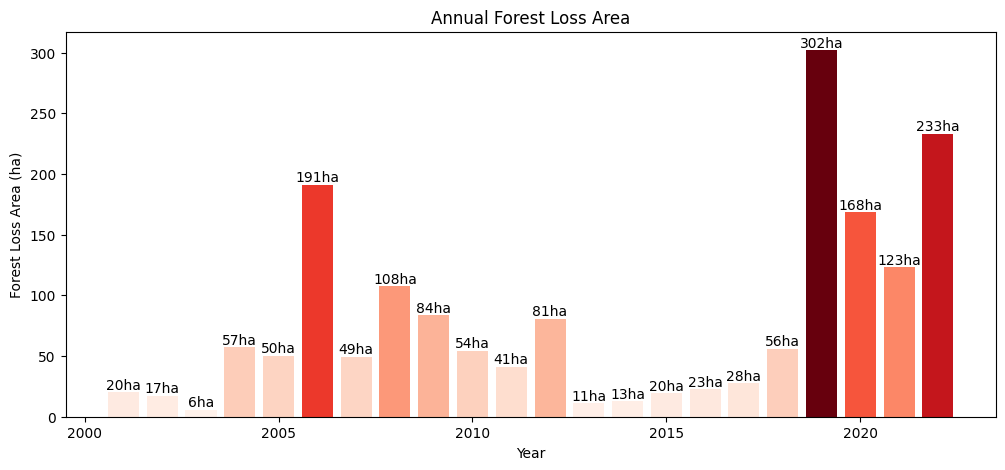

In [ ]:
# 연도별 산림손실 면적 막대 그래프 생성
fig, ax = plt.subplots(figsize=(12, 5))
colors = plt.cm.Reds(df['Loss_Area_ha'] / df['Loss_Area_ha'].max())
bars = ax.bar(df['Year'], df['Loss_Area_ha'], color=colors)

# 막대 위에 헥타르 단위로 면적 표시
for bar, area_ha in zip(bars, df['Loss_Area_ha']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{area_ha:.0f}ha', va='bottom', ha='center', color='black')

# 레이블 설정
ax.set_xlabel('Year')
ax.set_ylabel('Forest Loss Area (ha)')
ax.set_title('Annual Forest Loss Area')

# 차트를 이미지로 저장
plt.savefig('forest_loss_area_colored.png', dpi=100)
plt.show()